# Project: Wrangling and Analyze Data

## Table of Contents
<ul>
<li><a href="#Gather">Data Gathering</a></li>
<li><a href="#Assess">Assessing Data</a></li>
<li><a href="#Clean"> Cleaning Data</a></li>
<li><a href="#Store"> Storing Data</a></li>
<li><a href="#Eda">Analyzing and Visualizing Data</a></li>

</ul>

<a id='intro'></a>
## Introduction
> The dataset we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user <a href="https://twitter.com/dog_rates" >@dog_rates</a>, also known as <a href="https://en.wikipedia.org/wiki/WeRateDogs">WeRateDogs </a>. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 9 million followers and has received international media coverage.

In [5]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
from wordcloud import WordCloud, STOPWORDS

<a id='Gather'></a>
## Data Gathering 
1. Downloading Twitter archive data (twitter_archive_enhanced.csv)

In [6]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

2. Downloading the tweet image prediction using Requests library (image_predictions.tsv)

In [7]:
import requests
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)


with open("image-predictions.tsv", mode='wb') as file:
    file.write(response.content)
images_pred = pd.read_csv('image-predictions.tsv',sep='\t')

3. Querying additional data via Twitter API using Tweepy library (tweet_json.txt)

In [ ]:
# Register for your own Twitter Developer account your own keys
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

count = 0
fails_dict = {}
start = timer()
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print("Tweet is deleted")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [9]:
tweetsJson = [json.loads(line) for line in open('tweet_json.txt','r')] #using list compression to read the file line by line and load it
twitter_archive2 =  pd.DataFrame(tweetsJson)

<a id='Assess'></a>
## Assessing Data

### Visual Assessment

In [ ]:
twitter_archive

In [ ]:
images_pred

In [ ]:
twitter_archive2

### Programmatic Assessment

In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
images_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
images_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
twitter_archive2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2327 non-null   object 
 1   id                             2327 non-null   int64  
 2   id_str                         2327 non-null   object 
 3   full_text                      2327 non-null   object 
 4   truncated                      2327 non-null   bool   
 5   display_text_range             2327 non-null   object 
 6   entities                       2327 non-null   object 
 7   extended_entities              2057 non-null   object 
 8   source                         2327 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

In [18]:
twitter_archive.duplicated().sum()

0

In [19]:
images_pred.duplicated().sum()

0

In [20]:
twitter_archive2.retweeted.value_counts()

False    2327
Name: retweeted, dtype: int64

>No retweets. Cleaning won't be required.

### Quality issues
1. __Timestamp__ is not an object `twitter_archive` table
2. Invalid dog names `twitter_archive`
3. Unnecessary characters, hyperlinks etc in __text__ column `twitter_archive` table
4. Hyperlinks of __source__ column `twitter_archive` table
5. Drop rows that are not dogs `images_pred` table
6. Rename columns for clarity also assit wnen merging
7. __rating_denominator__ contains values not equal 10 `twitter_archive`
8. Drop unnecessary columns

### Tidiness issues
1. The last 4 columns of `twitter_archive` table can be one column
2. The 3 tables can be one table.

<a id='Clean'></a>
## Cleaning Data

In [21]:
twitter_archive_clean = twitter_archive.copy()
images_pred_clean = images_pred.copy()
twitter_archive2_clean = twitter_archive2.copy()

__Quality issue #8__<br>
 Create a function drop the columns that will not be used to start off in the all the tables.

##### Code

In [22]:
twitter_archive2_drop = pd.Series(['created_at', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status',
       'favorited', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status','retweeted'])
twitter_archive_drop = pd.Series(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls'])
images_pred_drop = pd.Series(['p1_conf','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog','img_num'])

def dropping(df, series):
    df.drop(series, axis = 1, inplace = True)
dropping(twitter_archive2_clean,twitter_archive2_drop)
dropping(twitter_archive_clean , twitter_archive_drop)
dropping(images_pred_clean , images_pred_drop)

##### Test

In [23]:
print(twitter_archive_clean.columns)
print(twitter_archive2_clean.columns)
print(images_pred_clean.columns)

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')
Index(['id', 'retweet_count', 'favorite_count'], dtype='object')
Index(['tweet_id', 'jpg_url', 'p1', 'p1_dog'], dtype='object')


__Quality issue #6__ <br>
Rename the *p1* in `images_pred_clean` table for clarity and *id* in `twitter_archive2_clean` table which will when merging.

In [24]:
images_pred_clean.rename(columns={'p1': 'dog_breed',},inplace=True)
twitter_archive2_clean.rename(columns={'id': 'tweet_id'},inplace=True)

##### Test

In [25]:
print(images_pred_clean.columns)
print(twitter_archive2_clean.columns)

Index(['tweet_id', 'jpg_url', 'dog_breed', 'p1_dog'], dtype='object')
Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')


__Quality issue #4__<br>
Remove the hyperlinks to only have the clear have a clear description of the tweet source.

##### Code

In [26]:
pattern=">(.*?)</a>" #using this pattern to get everything between > and </a>
for i in twitter_archive_clean.index:
    twitter_archive_clean.at[i, 'source'] = re.search(pattern, twitter_archive_clean.at[i, 'source']).group(1)

##### Test

In [27]:
twitter_archive_clean.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

__Quality issue #1__<br>
Convert Timestamp column's data type from object to datetime.

##### Code

In [28]:
dt = []
for ts in twitter_archive_clean.timestamp:
    dt.append(parse(ts))
twitter_archive_clean['timestamp'] = twitter_archive_clean.apply(lambda t: parse(t.timestamp), axis=1)


##### Test

In [29]:
twitter_archive_clean.timestamp.dtypes

datetime64[ns, tzutc()]

__Quality issue #7__ <br>
Since the <a href="https://knowyourmeme.com/memes/we-rate-dogs">unique rating system</a> of <a href="https://en.wikipedia.org/wiki/WeRateDogs">WeRateDogs</a>  says the raiting denominator is always 10, correct the values that did not conform to this. 

##### Code

In [30]:
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].apply(lambda x: 10 if x == 10 else 10)


##### Test

In [31]:
twitter_archive_clean.rating_denominator.unique()

array([10], dtype=int64)

__Quality isuue #2__ <br>
Replace the invalid dog names with *None*

##### Code

In [32]:
replace_values = ['a','an','this','my','his','unacceptable','incredibly','very','one','actually','mad','by','the','O']
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace(replace_values,'None')

##### Test

In [33]:
if 'replace_values' in twitter_archive_clean['name']:
    print(True)
else:
    print(False)

False


__Tidiness issue #1__ <br>
Melt the *doggo*, *floofer*, *pupper* and *puppo* to a *dog_stage* and then drop duplicates

##### Code

In [34]:
twitter_archive_clean = twitter_archive_clean.melt(id_vars=['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name'], value_name='dog_stage',var_name='variable')
twitter_archive_clean.drop(['variable'], axis = 1, inplace = True) #not needed
twitter_archive_clean = twitter_archive_clean.drop_duplicates() #entries doubled after melting so we dropped duplicates

##### Test

In [35]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None


__Quality issue #5__ <br>
Only going to use the algorithm #1 prediction since the cconfidence in its prediction was fairly high hence all other columns were dropped. So in this case to get only tweets that are dogs we want *p1_dog* to be true.

In [36]:
images_pred_clean = images_pred_clean.loc[images_pred_clean.p1_dog==True]
images_pred_clean.drop(['p1_dog'],axis=1,inplace=True)

In [37]:
images_pred_clean.head()

,tweet_id,jpg_url,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher


__Tidiness issue #2__ <br>
Merge all the tables into one.

##### Code

In [38]:
twitter_archive_master = pd.merge(pd.merge(twitter_archive_clean,images_pred_clean,on='tweet_id'),
                                  twitter_archive2_clean,on='tweet_id') #tweet_id was the only similar column

__Quality issue #3__ <br>
We going to remove: 
- twitter handles
- hyperlinks
- non-alphanumeric characters such as punctuation marks
- whitespace
- and transform tweet text into lowercase
- and remove stopwords <br>
This is done to be able to produce wordcloud for our tweets.

In [ ]:
from nltk.corpus import stopwords
additional  = ['rt','rts','retweet']
stop_words = set().union(stopwords.words('english'),additional) #words not adding much to a sentence.
twitter_archive_master['newtext'] = twitter_archive_master['text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in stop_words])

<a id='Store'></a>
## Storing Data

In [40]:
twitter_archive_master.to_csv("twitter_archive_master.csv",index=False) #storing data as csv file.

<a id='Eda'></a>
## Analyzing and Visualizing Data

### 1. Is there correlation between number of retweets and liked tweets?

> We are going to calculate the Pearson Correlation using this formula: <br>
> $r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N \sum{x^2}-(\sum{x})^2 ][N \sum{y^2}-(\sum{y})^2 }]}$

In [41]:
from scipy.stats import pearsonr 
corr, _ = pearsonr(twitter_archive_master['retweet_count'], twitter_archive_master['favorite_count'])
print("Pearson correlation is: % .3f" % corr)

Pearson correlation is:  0.867


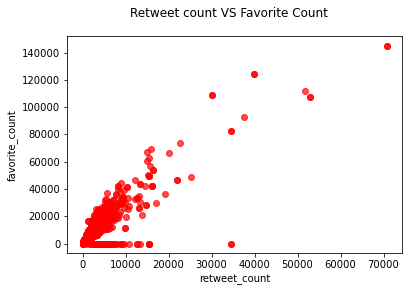

In [42]:
plt.suptitle("Retweet count VS Favorite Count")
plt.scatter(twitter_archive_master['retweet_count'], twitter_archive_master['favorite_count'], alpha=0.7,color="red")
plt.xlabel("retweet_count")
plt.ylabel("favorite_count");
plt.savefig("scatter.png")

There is a strong correlation between these 2 variables which could suggest people when they encounter a tweet they both like and retweet

### 2. Hours and days the user tweet most.

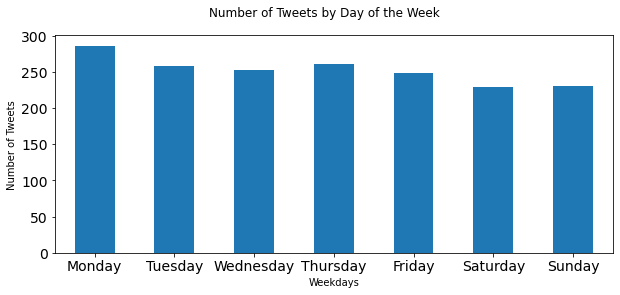

In [43]:
twitter_archive_master.text.groupby(twitter_archive_master.timestamp.dt.dayofweek).count().plot(figsize=(10,4), fontsize=14, kind='bar', rot=0)
plt.suptitle("Number of Tweets by Day of the Week")
plt.xlabel('Weekdays')
plt.ylabel('Number of Tweets')
plt.xticks(np.arange(7),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.savefig("day.png");

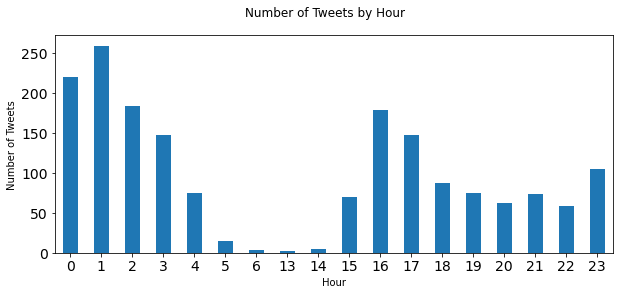

In [44]:
twitter_archive_master.text.groupby(twitter_archive_master.timestamp.dt.hour).count().plot(figsize=(10,4), fontsize=14, kind='bar', rot=0)
plt.suptitle('Number of Tweets by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.savefig("hour.png");

### 3. Create wordcloud to see words that are used most
           

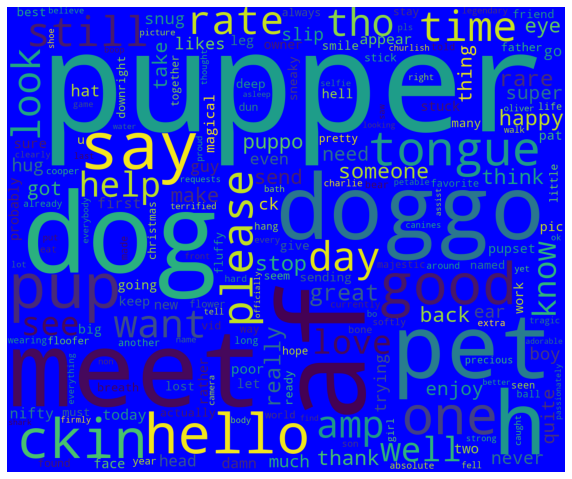

In [45]:
string = twitter_archive_master['newtext'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='blue',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(string)
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig("word.png");

### 4. Get top 10 most used hashtags

In [46]:
hashtags = twitter_archive_master['text'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() )))\
                     .sum(axis=0)\
                     .to_frame()\
                     .reset_index()\
                     .sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','frequency']

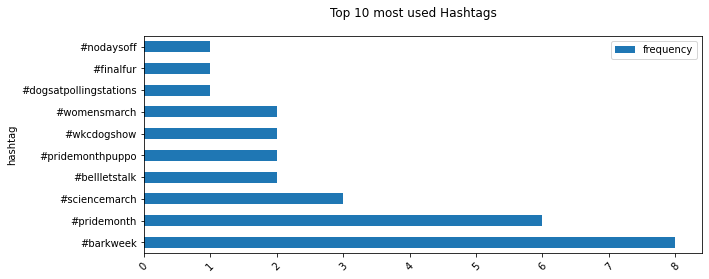

In [47]:
hashtags[:10].plot(figsize=(10,4), kind='barh',y='frequency',x='hashtag')
plt.grid(False)
plt.suptitle("Top 10 most used Hashtags")
plt.xticks(rotation=45)
plt.savefig("hash.png");

### 5. Which source the user use most when tweeting?

In [48]:
twitter_archive_master.source.value_counts()

Twitter for iPhone    1739
Twitter Web Client      20
TweetDeck                7
Name: source, dtype: int64

### 6. Get top 10 most dog breed

In [49]:
breed = twitter_archive_master['dog_breed'].value_counts().to_frame().reset_index()\
                     
breed.columns = ['breed','frequency']

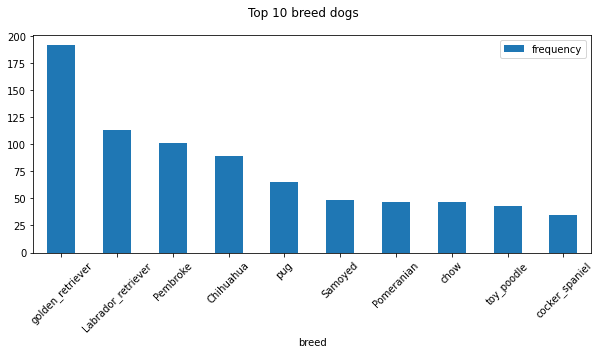

In [50]:
breed[:10].plot(figsize=(10,4), kind='bar',y='frequency',x='breed')
plt.grid(False)
plt.suptitle("Top 10 breed dogs")
plt.xticks(rotation=45)
plt.savefig("breed.png");